In [24]:
import numpy as np
from matplotlib.image import imread
import pywt
import matplotlib.pyplot as plt
import cv2
import itertools
import os
import pandas as pd
import time
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
plt.rcParams.update({'font.size': 20})

## Test on Set14/Set5/Urban100/Manga109/BSD100

### Loading images

In [3]:
# Loading ALL images, really all
file_paths = []  
for root, dirs, files in os.walk("../../data/other"):
    for file in files:
        if file != '.DS_Store':
            file_path = os.path.join(root, file)
            file_paths.append(file_path)

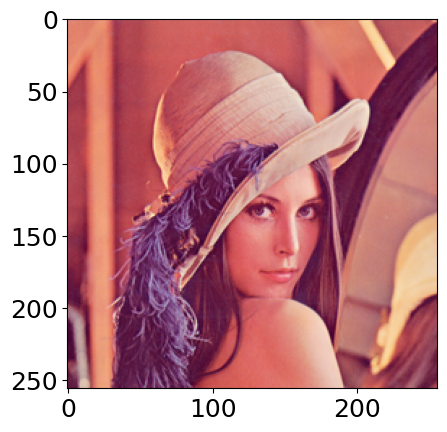

In [4]:
plt.imshow(imread(file_paths[3]))
plt.show()

In [5]:
def compress_image_with_pywt(image_path, wavelet='haar', level=2):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    coeffs = pywt.wavedec2(img, wavelet, mode="antireflect",  level=level)  

    coeffs_thresh = []
    coeffs_thresh.append(coeffs[0])
    for detail_coeffs in coeffs[1:]: 
        h, v, d = detail_coeffs
        h_thresh = pywt.threshold(h, np.inf, mode='hard')
        v_thresh = pywt.threshold(v, np.inf, mode='hard')
        d_thresh = pywt.threshold(d, np.inf, mode='hard')
        coeffs_thresh.append((h_thresh, v_thresh, d_thresh))

    reconstructed_img = pywt.waverec2(coeffs_thresh, wavelet)
    normalized_image = reconstructed_img
    return normalized_image, 4**level


In [16]:
maximum_level = 6
# using most common wavelets 
wavelets = ["haar","sym4" ,"sym20", "bior3.3", "db10", "coif1", "db20", "rbio3.3"]


psnr_values = {wavelet: [] for wavelet in wavelets}
compressions = {wavelet: [] for wavelet in wavelets}
ssims = {wavelet: [] for wavelet in wavelets}
times = {wavelet: [] for wavelet in wavelets}

## Image compression example

In [17]:
fig, axs = plt.subplots(len(wavelets), maximum_level, figsize=(20, 20))
psnr_values = {wavelet: [] for wavelet in wavelets}
compressions = {wavelet: [] for wavelet in wavelets}
ssims = {wavelet: [] for wavelet in wavelets}
test_iamge = np.mean(imread("../../data/other/lenna.png")*255,-1)
plt.ioff()
for ax in axs.flat:
    ax.tick_params(axis='both', which='major', labelsize=1)
    ax.tick_params(axis='both', which='minor', labelsize=1)  

/Users/WorkAndStudy/.pyenv/versions/3.11.1/envs/data-analysis/lib/python3.11/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(
/Users/WorkAndStudy/.pyenv/versions/3.11.1/envs/data-analysis/lib/python3.11/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
  warnings.warn(


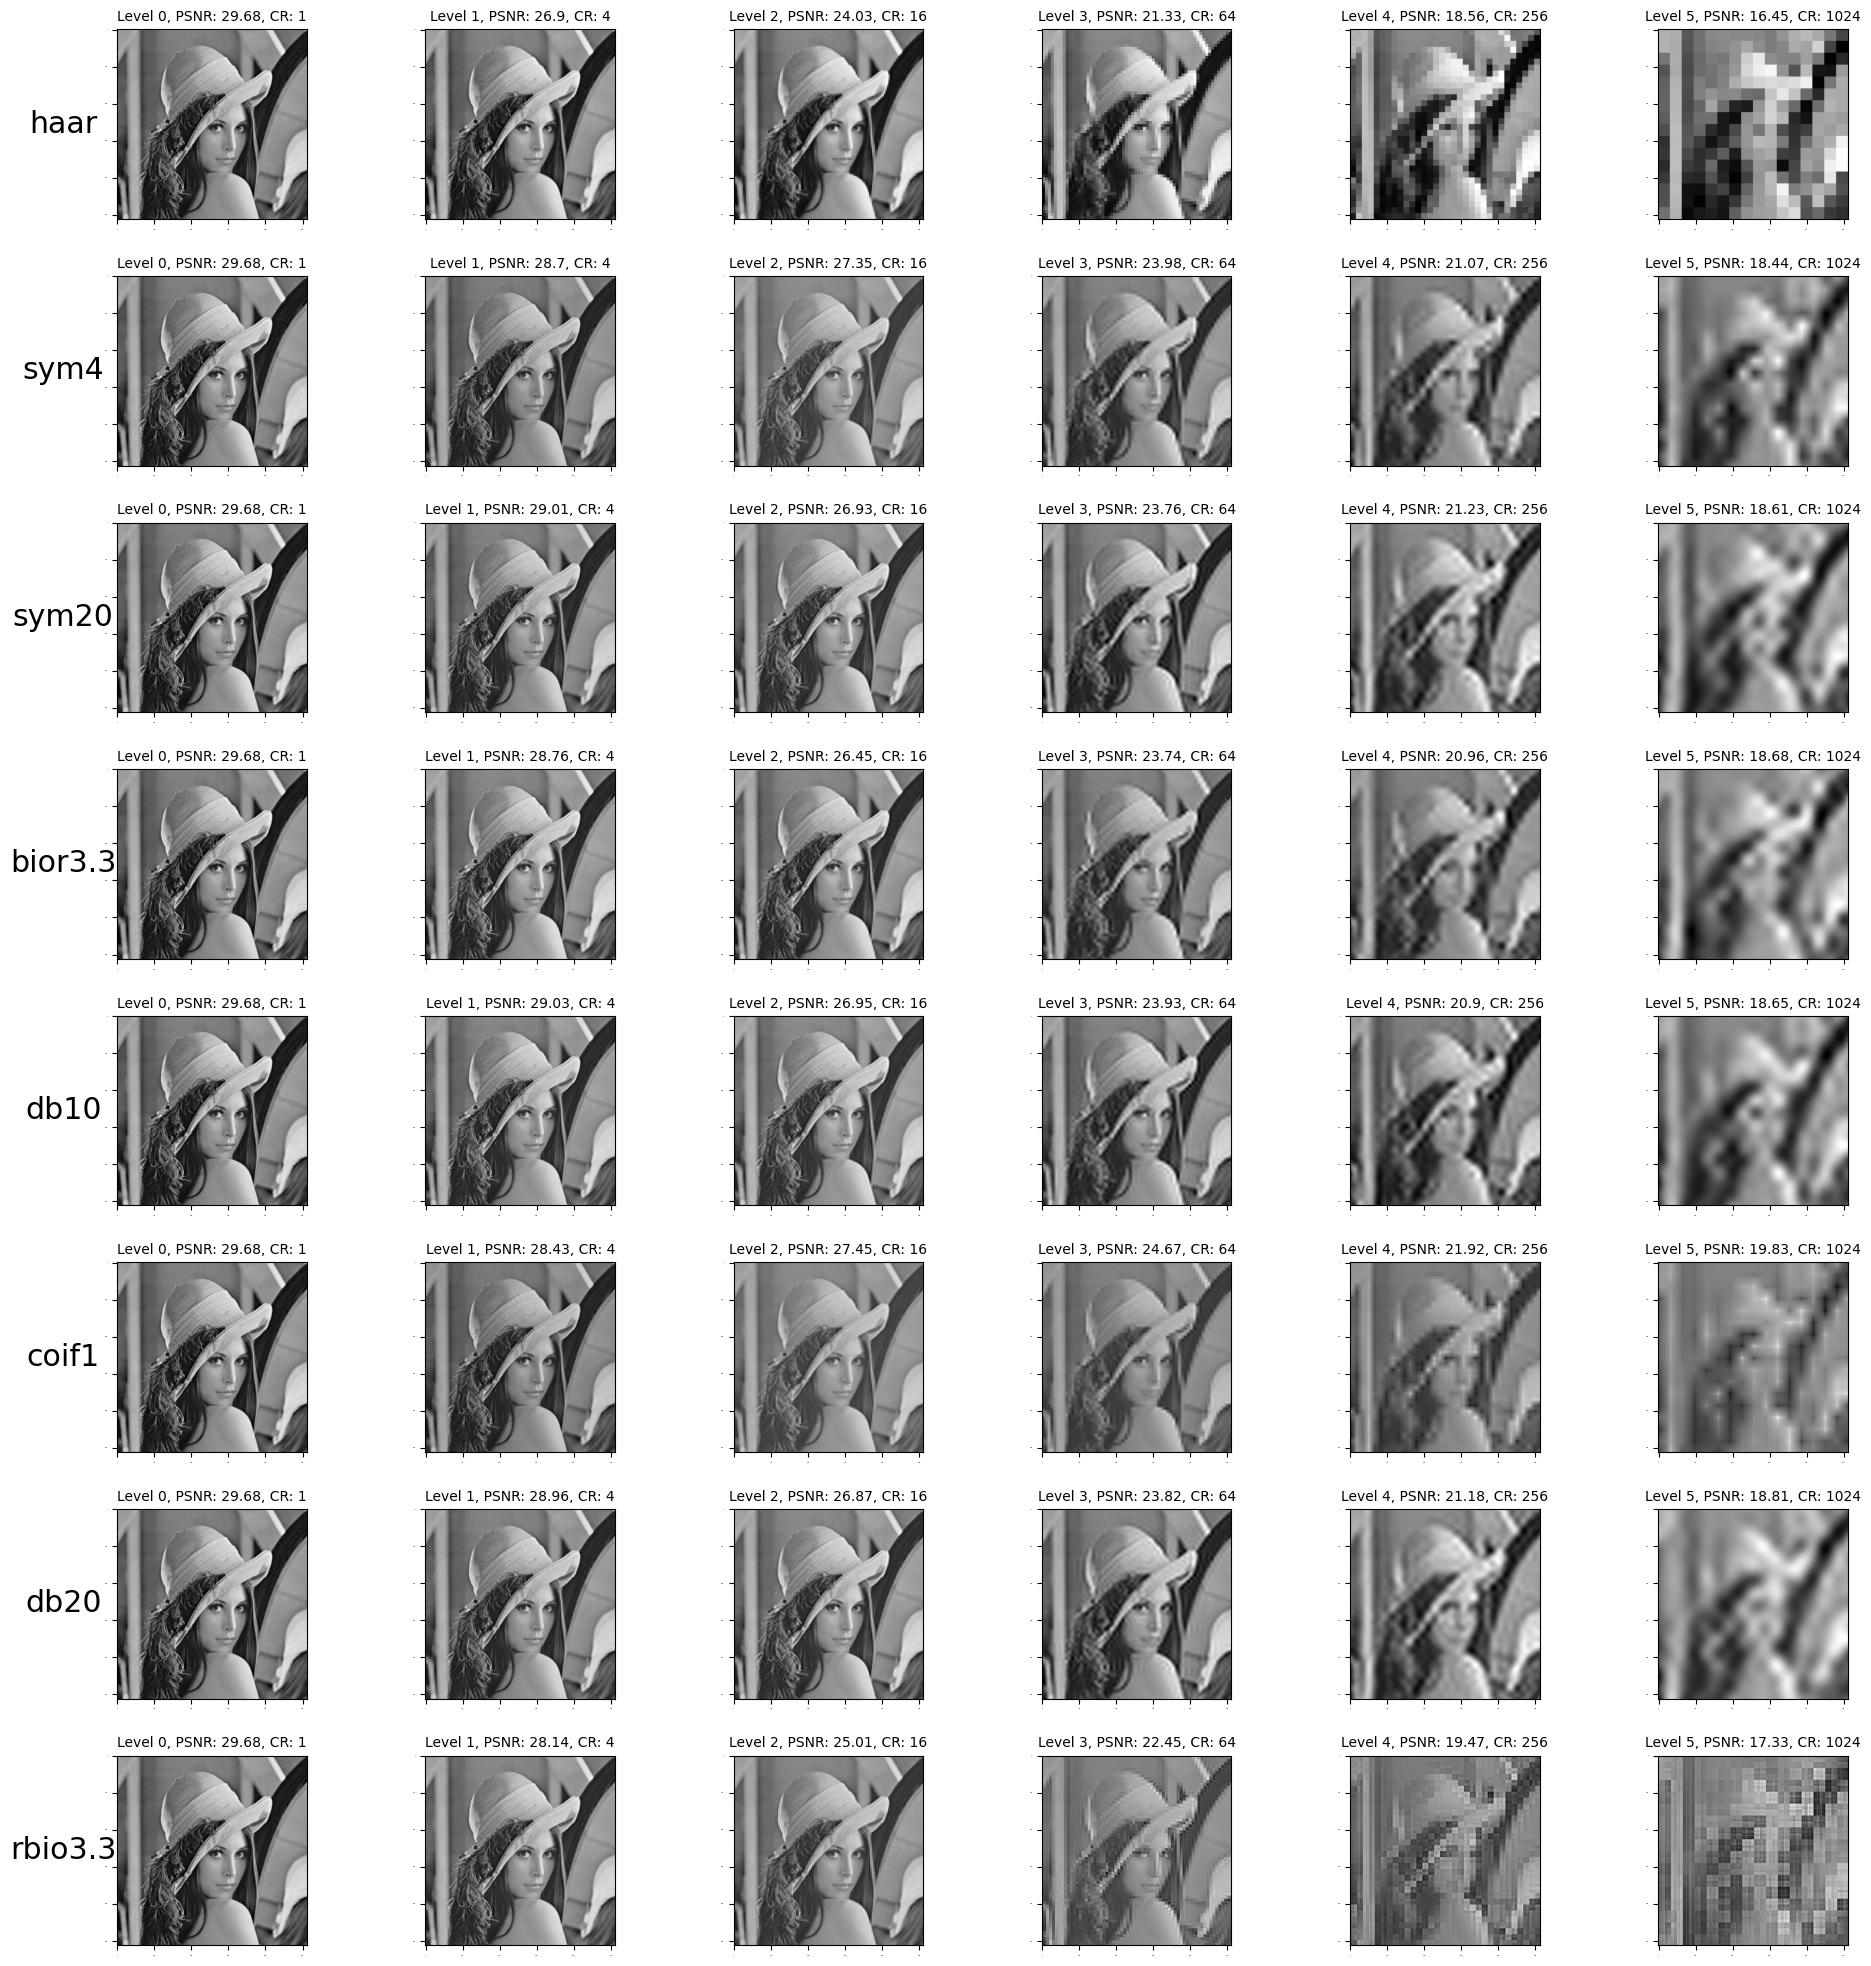

In [18]:

for level in range(maximum_level):
    for wave_index, wave in enumerate(wavelets):
        reconstructed_image, compression_rate = compress_image_with_pywt('../../data/other/lenna.png', wavelet=wave, level=level)
        

        psnr_metric = psnr(test_iamge, reconstructed_image, data_range=test_iamge.max() - reconstructed_image.min())
        ssim_metric = ssim(test_iamge, reconstructed_image, data_range=test_iamge.max() - reconstructed_image.min())
        axs[wave_index, level].imshow(reconstructed_image, cmap='gray')
        axs[wave_index, level].set_title(f'Level {level}, PSNR: {np.round(psnr_metric, 2)}, CR: {compression_rate}', fontsize=10)

        if level == 0:  
            axs[wave_index, level].set_ylabel(wave, rotation=0, size='large', labelpad=30, verticalalignment='center')

        psnr_values[wave].append(psnr_metric)
        compressions[wave].append(compression_rate)
        ssims[wave].append(ssim_metric)

plt.tight_layout()
plt.show()

## Gathering data by testing on all datasets

#### Resetting variables

In [19]:
psnr_values = {wavelet: [] for wavelet in wavelets}
compressions = {wavelet: [] for wavelet in wavelets}
ssims = {wavelet: [] for wavelet in wavelets}
times = {wavelet: [] for wavelet in wavelets}

In [20]:
for level in range(maximum_level):
    local_psnr_values = []
    local_compressions = []
    local_ssims = []
    local_times = []
    for wave_index, wave in enumerate(wavelets):
        for image_path in file_paths:
            base_image =  np.mean(imread(image_path)*255, -1)
            start_time = time.perf_counter()
            reconstructed_image, compression_rate = compress_image_with_pywt(image_path, wavelet=wave, level=level)
            end_time = time.perf_counter()
            if reconstructed_image.shape[0] == base_image.shape[0] and reconstructed_image.shape[1] == base_image.shape[1]:
                psnr_metric = psnr(base_image, reconstructed_image, data_range=base_image.max() - reconstructed_image.min())
                ssim_metric = ssim(base_image, reconstructed_image, data_range=base_image.max() - reconstructed_image.min())

            local_times.append(end_time - start_time)
            local_psnr_values.append(psnr_metric)
            local_compressions.append(compression_rate)
            local_ssims.append(ssim_metric)
        
        times[wave].append(np.mean(local_times))
        psnr_values[wave].append(np.mean(local_psnr_values))
        compressions[wave].append(np.mean(local_compressions))
        ssims[wave].append(np.mean(local_ssims))

/Users/WorkAndStudy/.pyenv/versions/3.11.1/envs/data-analysis/lib/python3.11/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 3 is too high: all coefficients will experience boundary effects.
  warnings.warn(


In [35]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
marker = itertools.cycle((',', '+', '.', 'o', '*')) 


# Compression time
for wavelet in wavelets:
    axs[0].plot(np.arange(1, maximum_level+1), times[wavelet],label=wavelet, marker=next(marker))
    axs[0].set_title('Compression time')
    axs[0].grid('on')
    axs[0].set_xlabel('Level')
    axs[0].set_ylabel('PSNR (dB)')
    axs[0].set_xlabel('Level')
    axs[0].set_ylabel('time (seconds)')

# Compression factor
for wavelet in wavelets:
    axs[1].plot(np.arange(1, maximum_level+1),  compressions[wavelet],label=wavelet, marker=next(marker))
    axs[1].set_title('Compression factor')
    axs[1].grid('on')
    axs[1].set_xlabel('Level')
    axs[1].set_ylabel('Times')

# PSNR
for wavelet in wavelets:
    axs[2].plot(np.arange(1, maximum_level+1), psnr_values[wavelet], label=wavelet, marker=next(marker))
    axs[2].set_title('PSNR')
    axs[2].grid('on')
    axs[2].set_xlabel('Level')
    axs[2].set_ylabel('PSNR (dB)')

# SSIM
for wavelet in wavelets:
    axs[3].plot(np.arange(1, maximum_level+1),  ssims[wavelet], label=wavelet, marker=next(marker))
    axs[3].set_title('SSIM')
    axs[3].grid('on')
    axs[3].set_xlabel('Level')
    axs[3].set_ylabel('SSIM (%)')
    handles, labels = axs[3].get_legend_handles_labels()


fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.0, -0.001), ncol=len(wavelets))
plt.tight_layout()
plt.show()

TypeError: Legend.__init__() got an unexpected keyword argument 'lineweight'